In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-transaction-prediction/test.csv
/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv
/kaggle/input/santander-customer-transaction-prediction/train.csv


## Prep

In [2]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

### Overview

In [3]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['target'], axis=1)

df_train = pd.read_csv('../input/santander-customer-transaction-prediction/train.csv')
df_test = pd.read_csv('../input/santander-customer-transaction-prediction/test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['target'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 200000
Number of Test Examples = 200000

Training X Shape = (200000, 202)
Training y Shape = 200000

Test X Shape = (200000, 201)
Test y Shape = 200000

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)
Index(['ID_code', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5',
       'var_6', 'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)


Train contains:  

* **ID_code** (string);  
* **target**;  
* **200** numerical variables, named from **var_0** to **var_199**;

Test contains:  

* **ID_code** (string);  
* **200** numerical variables, named from **var_0** to **var_199**;


Let's check if there are any missing data. We will also chech the type of data.

In [4]:
print(df_train.info())
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB
None


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
178122,train_178122,0,14.6687,-6.6924,5.3444,6.1958,11.0827,5.6294,5.1067,13.5447,...,3.2136,2.9589,1.1745,4.2632,22.3717,-2.2851,5.1574,9.1144,14.1985,12.7795
123305,train_123305,0,12.8062,1.2855,9.3658,7.2584,9.2251,-5.2673,4.6885,14.3321,...,1.4310,10.3307,1.2352,8.2756,14.3364,-1.0635,7.4963,7.2212,14.0397,-4.0626
142056,train_142056,0,12.3430,-10.4533,10.5820,9.4485,14.4414,-15.1428,6.4624,22.0927,...,6.1929,5.0881,3.1366,8.8452,25.4265,0.6352,5.8957,7.6363,16.4168,-6.8626


In [5]:
print(df_test.info())
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB
None


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
183505,test_183505,6.7378,-4.4941,12.2226,7.4237,10.0814,-0.1195,3.6890,14.3863,-0.1213,...,8.1412,9.8542,1.7480,-1.7893,23.1452,0.3722,7.0544,7.7408,18.7988,-28.8471
27091,test_27091,6.2006,-0.1810,14.0730,3.1476,12.8373,-2.5399,5.7262,11.8884,-3.0351,...,6.6035,15.1424,-0.3759,-0.1974,22.5145,3.1565,3.7770,9.0294,11.7801,-18.7113
165231,test_165231,12.2531,7.9309,12.9442,7.0731,10.5851,-20.6039,7.7382,17.5649,1.5460,...,-0.2709,8.2635,1.3328,3.6303,14.9952,1.4158,-0.3265,7.5385,15.1228,1.5258


### Missing Values

In [6]:
def display_missing(df):     
        missing_val_count_by_column = (df.isnull().sum())
        print(missing_val_count_by_column[missing_val_count_by_column > 0])
        print('\n')

for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
Series([], dtype: int64)


Test Set
Series([], dtype: int64)




There are no missing data in train and test datasets. 

### Numerical Values

In [7]:
df_train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [8]:
df_test.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


We can make few observations here:   

* standard deviation is relatively large for both train and test variable data;  
* min, max, mean, std values for train and test data looks quite close;  
* mean values are distributed over a large range.

The number of values in train and test set is the same. Let's plot the scatter plot for train and test set for few of the features.


In [9]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='x')
        plt.xlabel(feature, fontsize=9)
    plt.show();

We will show just 5% of the data. On x axis we show train values and on the y axis we show the test values.

<Figure size 432x288 with 0 Axes>

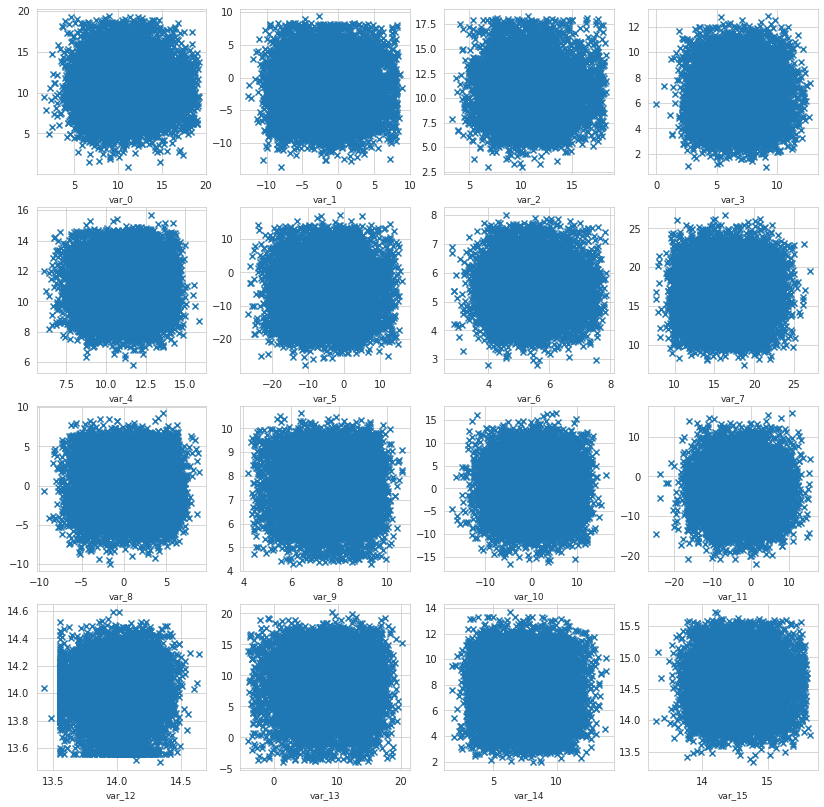

In [10]:
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
           'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
           ]
plot_feature_scatter(df_train[::20],df_test[::20], features)

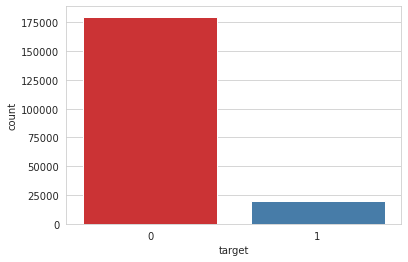

In [11]:
sns.countplot(df_train['target'], palette='Set1')

In [12]:
print("There are {}% target values with 1".format(100 * df_train["target"].value_counts()[1]/ df_train.shape[0]))

There are 10.049% target values with 1


### Features correlation

We now calculate the correlations between the features in train set.  

In [13]:
features = df_train.columns.values[2:202]
df_train[features].corr()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
var_0,1.000000,-0.000544,0.006573,0.003801,0.001326,0.003046,0.006983,0.002429,0.004962,-0.002613,...,0.002752,0.000206,-0.005373,0.001616,-0.001514,0.002073,0.004386,-0.000753,-0.005776,0.003850
var_1,-0.000544,1.000000,0.003980,0.000010,0.000303,-0.000902,0.003258,0.001511,0.004098,-0.000832,...,0.006627,0.003621,-0.002604,0.001153,-0.002557,-0.000785,-0.000377,-0.004157,-0.004861,0.002287
var_2,0.006573,0.003980,1.000000,0.001001,0.000723,0.001569,0.000883,-0.000991,0.002648,-0.001932,...,0.000197,0.001285,-0.003400,0.000549,0.002104,-0.001070,0.003952,0.001078,-0.000877,0.003855
var_3,0.003801,0.000010,0.001001,1.000000,-0.000322,0.003253,-0.000774,0.002500,0.003553,-0.000826,...,0.000151,0.002445,-0.001530,-0.001699,-0.001054,0.001206,-0.002800,0.001164,-0.001651,0.000506
var_4,0.001326,0.000303,0.000723,-0.000322,1.000000,-0.001368,0.000049,0.004549,0.001194,-0.000918,...,0.001514,0.004357,0.003347,0.000813,-0.000068,0.003706,0.000513,-0.000046,-0.001821,-0.000786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,0.002073,-0.000785,-0.001070,0.001206,0.003706,-0.001274,0.001244,0.001854,0.001396,-0.000868,...,0.004571,0.000870,-0.004745,-0.003143,-0.001201,1.000000,0.002517,-0.004170,-0.000536,0.002042
var_196,0.004386,-0.000377,0.003952,-0.002800,0.000513,0.002880,0.005378,0.001045,-0.003242,0.000052,...,-0.000847,0.002466,-0.001386,-0.005308,-0.005040,0.002517,1.000000,-0.000454,0.000253,0.000607
var_197,-0.000753,-0.004157,0.001078,0.001164,-0.000046,-0.000535,-0.003565,0.003466,-0.004583,0.003701,...,-0.004974,0.000906,-0.000527,0.005068,0.000884,-0.004170,-0.000454,1.000000,0.001183,0.004991
var_198,-0.005776,-0.004861,-0.000877,-0.001651,-0.001821,-0.000953,-0.003025,0.000650,0.002950,0.002343,...,-0.000153,-0.000067,0.003451,0.001646,0.003194,-0.000536,0.000253,0.001183,1.000000,-0.004731


In [14]:
df_train[features].corr().abs().unstack()

var_0    var_0      1.000000
         var_1      0.000544
         var_2      0.006573
         var_3      0.003801
         var_4      0.001326
                      ...   
var_199  var_195    0.002042
         var_196    0.000607
         var_197    0.004991
         var_198    0.004731
         var_199    1.000000
Length: 40000, dtype: float64

The following table shows the 10 least correlated features.

In [15]:
correlations = df_train[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

,level_0,level_1,0
0,var_75,var_191,2.703975e-08
1,var_191,var_75,2.703975e-08
2,var_173,var_6,5.942735e-08
3,var_6,var_173,5.942735e-08
4,var_126,var_109,1.313947e-07
5,var_109,var_126,1.313947e-07
6,var_144,var_27,1.772502e-07
7,var_27,var_144,1.772502e-07
8,var_177,var_100,3.116544e-07
9,var_100,var_177,3.116544e-07


Let's look to the top most correlated features, besides the same feature pairs.

In [16]:
correlations.tail(10)

,level_0,level_1,0
39790,var_183,var_189,0.009359
39791,var_189,var_183,0.009359
39792,var_174,var_81,0.009490
39793,var_81,var_174,0.009490
39794,var_81,var_165,0.009714
39795,var_165,var_81,0.009714
39796,var_53,var_148,0.009788
39797,var_148,var_53,0.009788
39798,var_26,var_139,0.009844
39799,var_139,var_26,0.009844


The correlation between the features is very small. 

### Duplicate values

Let's now check how many duplicate values exists per columns.

In [17]:
features = df_train.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = df_train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = df_test[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])
display(pd.DataFrame(unique_max_train))
display(pd.DataFrame(unique_max_test))

,0,1,2
0,var_0,11,10.6829
1,var_1,10,-2.4313
2,var_2,12,9.1497
3,var_3,15,6.8029
4,var_4,15,10.8911
...,...,...,...
195,var_195,17,-0.9350
196,var_196,8,1.7538
197,var_197,23,8.0477
198,var_198,13,16.8760


,0,1,2
0,var_0,20,9.5368
1,var_1,18,-3.6600
2,var_2,21,10.3544
3,var_3,22,8.5594
4,var_4,24,10.8383
...,...,...,...
195,var_195,27,-0.2137
196,var_196,16,6.0909
197,var_197,34,9.5016
198,var_198,20,15.8497


Let's show the top 15 max of duplicate values per train set.

In [18]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,108,126,12,91,103,148,71,161,25,125,169,166,133,43
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,var_125,var_169,var_166,var_133,var_43
Max duplicates,1084,313,305,203,66,61,59,54,52,41,40,39,39,39,39
Value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723,12.5159,5.6941,2.7306,6.8632,11.4522


Let's see also the top 15 number of duplicates values per test set.

In [19]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,126,108,12,91,103,148,161,25,71,43,166,125,169,133
Feature,var_68,var_126,var_108,var_12,var_91,var_103,var_148,var_161,var_25,var_71,var_43,var_166,var_125,var_169,var_133
Max duplicates,1104,307,302,188,86,78,74,69,60,60,58,53,53,51,50
Value,5.0197,11.5357,14.1999,13.5546,6.9939,1.4659,4.0004,5.7114,13.5965,0.5389,11.5738,2.8446,12.2189,5.8455,6.6873


Same columns in train and test set have the same or very close number of duplicates of same or very close values. This is an interesting pattern that we might be able to use in the future.

## Feature engineering

Let's  start from calculating a few aggregated values for the existing features.

In [20]:
idx = features = df_train.columns.values[2:202]
for df in [df_test, df_train]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

Let's check the new created features.

In [21]:
df_train[df_train.columns[202:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1456.3182,-21.4494,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
3,1288.2319,-35.1659,38.1015,6.441159,9.594064,-0.480116,2.630499,6.70260
4,1354.2310,-65.4863,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735


In [22]:
df_test[df_test.columns[201:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1416.6404,-31.9891,42.0248,7.083202,9.910632,-0.088518,1.871262,7.31440
1,1249.6860,-41.1924,35.6020,6.248430,9.541267,-0.559785,3.391068,6.43960
2,1430.2599,-34.3488,39.3654,7.151299,9.967466,-0.135084,2.326901,7.26355
3,1411.4447,-21.4797,40.3383,7.057223,8.257204,-0.167741,2.253054,6.89675
4,1423.7364,-24.8254,45.5510,7.118682,10.043542,0.293484,2.044943,6.83375


In [23]:
t0 = df_train.loc[df_train['target'] == 0]
t0

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_198,var_199,sum,min,max,mean,std,skew,kurt,med
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,12.7803,-1.0914,1456.3182,-21.4494,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,18.3560,1.9518,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,14.7222,0.3965,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,17.9697,-8.9996,1288.2319,-35.1659,38.1015,6.441159,9.594064,-0.480116,2.630499,6.70260
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,17.9974,-8.8104,1354.2310,-65.4863,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,16.6660,-17.8661,1349.0825,-23.6064,35.4923,6.745412,9.568606,-0.048360,0.815615,6.41060
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,15.9054,0.3388,1350.6997,-39.6406,38.8105,6.753499,10.308092,-0.553757,2.620481,6.57875
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,13.8329,4.1995,1374.9384,-49.5007,43.0307,6.874692,9.821335,-0.750798,5.837304,6.40910
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,15.5289,-13.9001,1388.1757,-42.9704,46.4915,6.940879,10.989741,-0.175745,3.526916,6.69070


In [24]:
t1 = df_train.loc[df_train['target'] == 1]
t1

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_198,var_199,sum,min,max,mean,std,skew,kurt,med
13,train_13,1,16.3699,1.5934,16.7395,7.3330,12.1450,5.9004,4.8222,20.9729,...,15.6064,-10.8529,1387.4958,-21.2631,43.2469,6.937479,9.094237,0.331609,1.695688,6.82455
29,train_29,1,5.3301,-2.6064,13.1913,3.1193,6.6483,-6.5659,5.9064,15.2341,...,17.4105,-14.6897,1316.2279,-21.7322,39.3510,6.581140,9.206875,-0.099399,1.109169,6.69360
63,train_63,1,7.7072,0.0183,9.9974,8.3524,9.2886,-13.3627,6.0425,10.1108,...,15.7685,5.4769,1342.4089,-33.7053,29.9410,6.712044,9.358747,-0.464280,1.439415,7.07115
65,train_65,1,10.5358,-2.5439,8.7394,6.7548,14.4099,-3.8724,5.1584,15.8381,...,15.1340,3.8449,1316.0340,-33.5923,35.6287,6.580170,9.632892,-0.328077,2.278068,6.56910
71,train_71,1,6.7547,2.5973,14.2141,8.3514,7.4942,-1.3055,4.2336,15.0243,...,18.9013,13.3447,1524.2799,-27.7489,49.6819,7.621399,9.497342,0.256815,2.582569,7.59360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199966,train_199966,1,13.5797,2.5526,6.0512,5.2730,12.2182,-3.4048,7.3623,17.8372,...,9.5440,4.2493,1287.6429,-30.1162,31.6602,6.438214,8.804743,-0.263069,1.786023,6.52270
199976,train_199976,1,7.9663,-2.8485,9.0919,7.3298,9.6690,-16.7872,4.5094,12.4351,...,14.3604,-1.6688,1332.4349,-19.7242,35.7633,6.662174,8.793638,0.003849,0.901957,6.76150
199981,train_199981,1,12.8140,0.6386,14.1657,7.1044,8.9365,-0.3274,6.5949,14.6078,...,16.0341,7.3809,1383.4933,-32.8149,34.5262,6.917467,9.601411,-0.381867,2.420952,6.71250
199986,train_199986,1,12.0298,-8.7800,7.7071,7.4015,9.2305,-16.2174,5.9064,17.9268,...,15.0031,-0.3659,1422.1546,-21.4366,37.9327,7.110773,9.216567,0.046649,1.201651,6.47350


In [25]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)        
    plt.show();

Let's check the distribution of these new, engineered features.  

We plot first the distribution of new features, grouped by value of corresponding `target` values.

<Figure size 432x288 with 0 Axes>

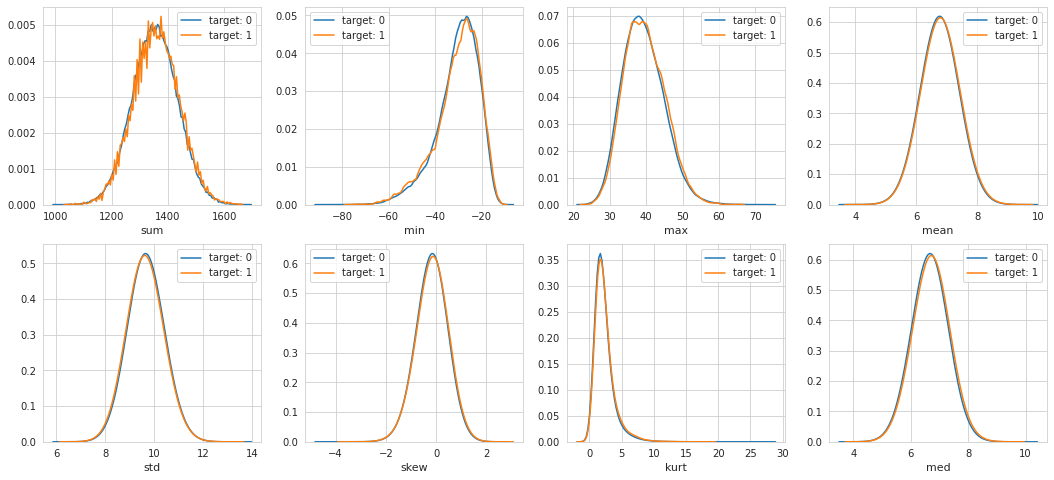

In [26]:
t0 = df_train.loc[df_train['target'] == 0]
t1 = df_train.loc[df_train['target'] == 1]
features = df_train.columns.values[202:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

Let's show the distribution of new features values for train and test.

<Figure size 432x288 with 0 Axes>

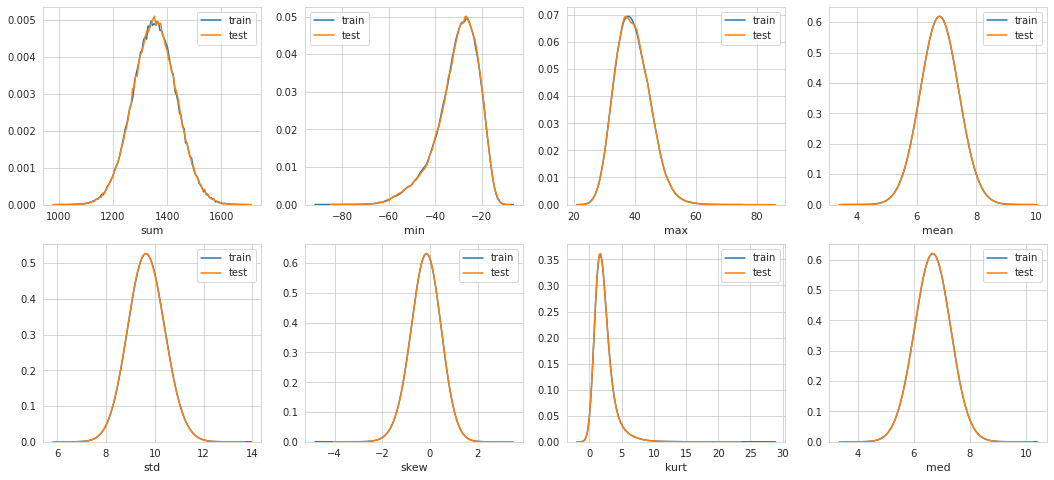

In [27]:
features = df_train.columns.values[202:]
plot_new_feature_distribution(df_train, df_test, 'train', 'test', features)

Let's check how many features we have now.

In [28]:
print('Train and test columns: {} {}'.format(len(df_train.columns), len(df_test.columns)))

Train and test columns: 210 209


## Modeling

From the train columns list, we drop the ID and target to form the features list.

In [29]:
features = [c for c in df_train.columns if c not in ['ID_code', 'target']]
target = df_train['target']

We define the hyperparameters for the model.

In [30]:
# Parameters for training
param = {
    'bagging_freq': 5, #  default = 0 means disable bagging; k means perform bagging at every k iteration
    'bagging_fraction': 0.4, # 0.0 < bagging_fraction <= 1.0, default = 1.0, randomly select part of data without resampling
    'boost_from_average':'false', # default = true, adjusts initial score to the mean of labels for faster convergence
  # 'boosting': 'gbdt', # default = 'gbdt', traditional Gradient Boosting Decision Tree
    'feature_fraction': 0.05,
    'learning_rate': 0.01, # > 0.0, default = 0.1, shrinkage rate
  # 'max_depth': -1,  # < 0 means no limit, default = -1. This is used to deal with over-fitting when #data is small. Tree still grows leaf-wise
    'metric':'auc',
    'min_data_in_leaf': 80, # >= 0, default = 20
    'min_sum_hessian_in_leaf': 10.0, # default = 1e-3, minimal sum hessian in one leaf. Like min_data_in_leaf, it can be used to deal with over-fitting
    'num_leaves': 13, # default = 31, 1 < num_leaves <= 131072
    'num_threads': 8, # default = 0 , for the best speed, set this to the number of real CPU cores, not the number of threads
  # 'tree_learner': 'serial', # default = serial, single machine tree learner
    'objective': 'binary', # default = regression, binary log loss classification (or logistic regression), requires labels in {0, 1}
  # 'verbosity': 1 # default = 1, type = int, aliases: verbose controls the level of LightGBM’s verbosity < 0: Fatal, = 0: Error (Warning), = 1: Info, > 1: Debug
}

We run the model.

In [31]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)

oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
df_feature_importance = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)): # Every fold has 180000 trn, 20000 val
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_boost_round = 1000000 # Number of boosting iterations.
    valid_sets = [trn_data, val_data]
    verbose_eval=1000   # Evaluation metric is printed every 1000 boosting stages.
    early_stopping_rounds = 3000 # Validation score needs to improve at least every 3000 rounds to continue training.
    
    clf = lgb.train(params=param, train_set=trn_data, num_boost_round=num_boost_round, valid_sets=valid_sets, verbose_eval=verbose_eval, early_stopping_rounds=early_stopping_rounds)
    
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration) # If early stopping is enabled during training, you can get predictions from the best iteration with .best_iteration
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    df_feature_importance = pd.concat([df_feature_importance, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds
[1000]	training's auc: 0.900688	valid_1's auc: 0.881785
[2000]	training's auc: 0.911592	valid_1's auc: 0.888668
[3000]	training's auc: 0.919073	valid_1's auc: 0.892539
[4000]	training's auc: 0.92493	valid_1's auc: 0.895117
[5000]	training's auc: 0.929779	valid_1's auc: 0.896903
[6000]	training's auc: 0.934117	valid_1's auc: 0.897716
[7000]	training's auc: 0.938033	valid_1's auc: 0.8984
[8000]	training's auc: 0.941701	valid_1's auc: 0.898689
[9000]	training's auc: 0.94528	valid_1's auc: 0.899
[10000]	training's auc: 0.948639	valid_1's auc: 0.899159
[11000]	training's auc: 0.951854	valid_1's auc: 0.899314
[12000]	training's auc: 0.954937	valid_1's auc: 0.89954
[13000]	training's auc: 0.957916	valid_1's auc: 0.899413
[14000]	training's auc: 0.960689	valid_1's auc: 0.899371
Early stopping, best iteration is:
[11934]	training's auc: 0.954724	valid_1's auc: 0.899589
Fold 1
Training until validation scores don't improve for

Let's check the feature importance.

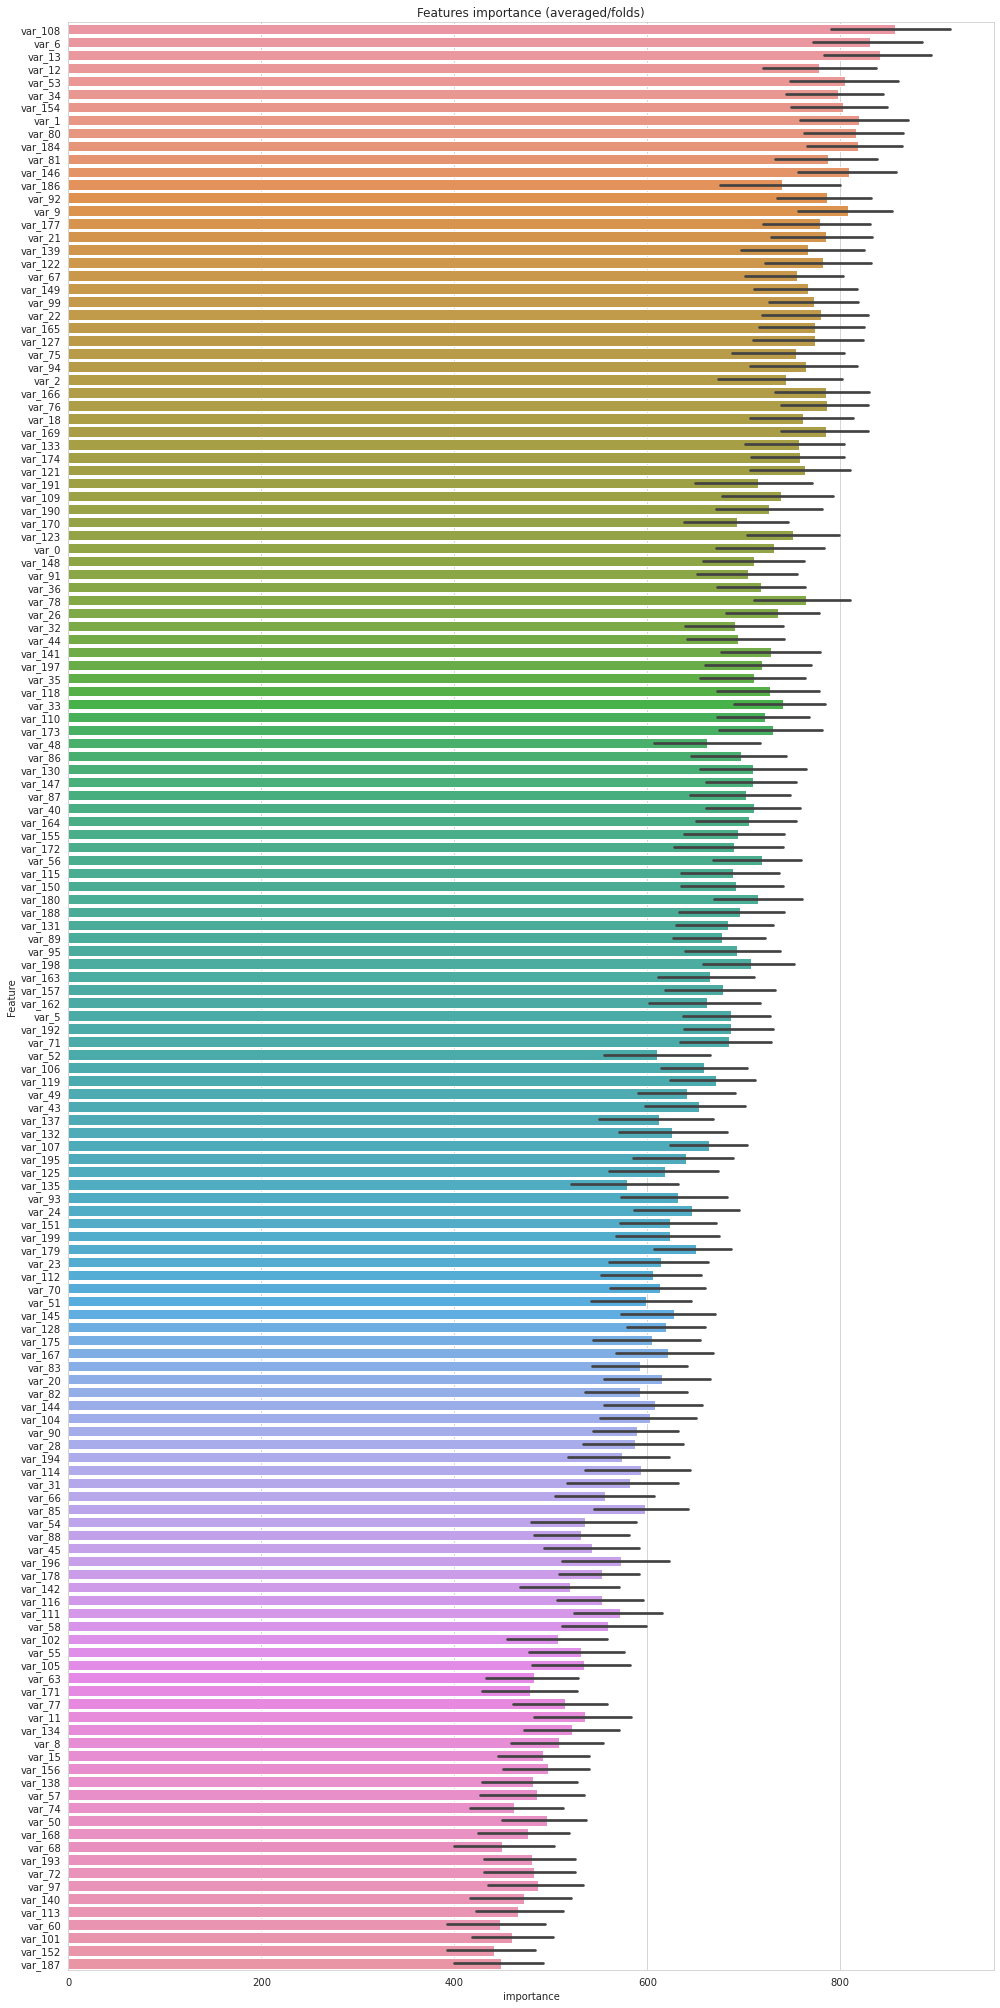

In [32]:
cols = (df_feature_importance[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = df_feature_importance.loc[df_feature_importance.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

## Submission

In [33]:
output = pd.DataFrame({
        "ID_code": df_test["ID_code"].values,
        "target": predictions
    })
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
